# Challenge 1 - ret2win
hosted at the ROP Emporium



## ROP Emporium
<h4>This is a great place to learn about Return Oriented Programming, one of the sexier buffer overflow exploitation techniques used today. This is a CTF site where you attempt to exploit a binary using ROP in order to read out flag.txt </h4>

<a href="https://ropemporium.com/" target="_blank"><img src="https://1.bp.blogspot.com/-5Py6qw3W7mk/XxubymSzn6I/AAAAAAAAAok/5NjfpufdrJ0nHYcmvS8B9QHJMPw-DaS4ACLcBGAsYHQ/s1372/Screen%2BShot%2B2020-07-24%2Bat%2B10.40.44%2BPM.png" 
alt="FOOL, THE IMAGE IS GONE" width="240" height="180" border="10" /></a>

<h4>ROP Emporium offers their binaries in 4 architectural flavors, to start out I'll be using x86_64 (very basic I know) but I plan to run through the gauntlet again at least one more time to learn about ARM Pointer Auth Codes.</h4>



# 
<h1> Objective: Locate a method that you want to call within the binary. Call it by overwriting a saved return address on the stack.</h1>




<h3>Starting off with a little file inspection:</h3>



# 
 



In [92]:
import os
cmd = "file ret2win"
os.system(cmd)

ret2win: ELF 64-bit LSB executable, x86-64, version 1 (SYSV), dynamically linked, interpreter /lib64/ld-linux-x86-64.so.2, for GNU/Linux 3.2.0, BuildID[sha1]=19abc0b3bb228157af55b8e16af7316d54ab0597, not stripped


0

# 
 



<h3>
So were dealing with a 64bit ELF (Executable and Linkable Format) in little endian (LSB stands for Least Significant Byte) we can also check this manually by looking at the sixth byte in the ELF header using a debugger (it's either 1 or 2 if little or big endian).
</h3>


# 
 



In [1]:
import os
cmd = "emit ret2win | peek"
os.system(cmd)

---------------------------------------------------------------------------
0000: 7F 45 4C 46 02 01 01 00 00 00 00 00 00 00 00 00 02  .ELF.............
0011: 00 3E 00 01 00 00 00 B0 05 40 00 00 00 00 00 40 00  .>.......@.....@.
0022: 00 00 00 00 00 00 58 1A 00 00 00 00 00 00 00 00 00  ......X..........
0033: 00 40 00 38 00 09 00 40 00 1D 00 1C 00 06 00 00 00  .@.8...@.........
0044: 04 00 00 00 40 00 00 00 00 00 00 00 40 00 40 00 00  ....@.......@.@..
0055: 00 00 00 40 00 40 00 00 00 00 00 F8 01 00 00 00 00  ...@.@...........
0066: 00 00 F8 01 00 00 00 00 00 00 08 00 00 00 00 00 00  .................
0077: 00 03 00 00 00 04 00 00 00 38 02 00 00 00 00 00 00  .........8.......
0088: 38 02 40 00 00 00 00 00 38 02 40 00 00 00 00 00 1C  8.@.....8.@......
0099: 00 00 00 00 00 00 00 1C 00 00 00 00 00 00 00 01 00  .................
---------------------------------------------------------------------------


0

# 
 




<h3>
The file is not stripped meaning the author of the exe compiled without stripping their function names, so the next step would be to check all the named functions in the binary using radare2 in hopes of finding some leads.
</h3>



# 
 



In [1]:
cmd = "r2 -AAA ret2win -c afl"

# 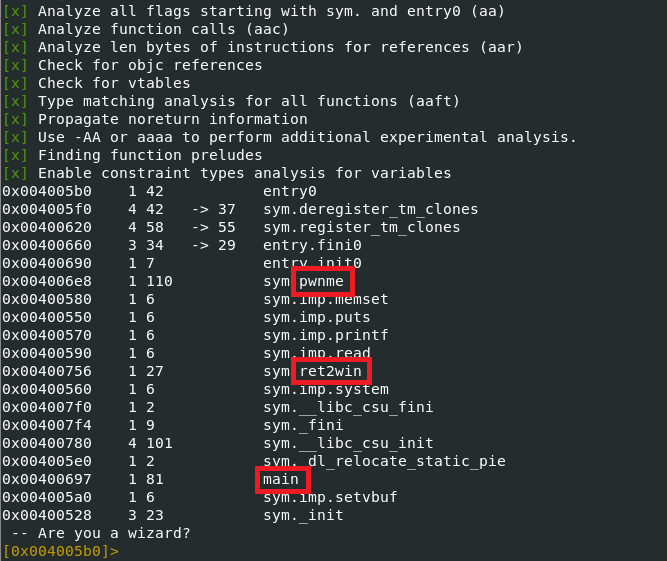
 



<h3>
I'm not going to explain the command arguments, everything is pretty cut and dry (plus the man page exists). What it spits out is a memory address of our location (at entry0 which corresponds to the _start function) within the binary and a list of functions for us to analyze.
</h3>

<h3>
We can see that there are indeed a few interesting functions: <strong>pwnme, ret2win,</strong> and <strong> main</strong></h3> 

<h3>
Main is the most logical place to start so lets use the 'seek' command in radare to jump into main and the 'pdf' command to print out the disassembled function.
    </h3>

# 
 



In [ ]:

cmd = "r2 -q -AAA ret2win -c 's main' -c pdf"


# 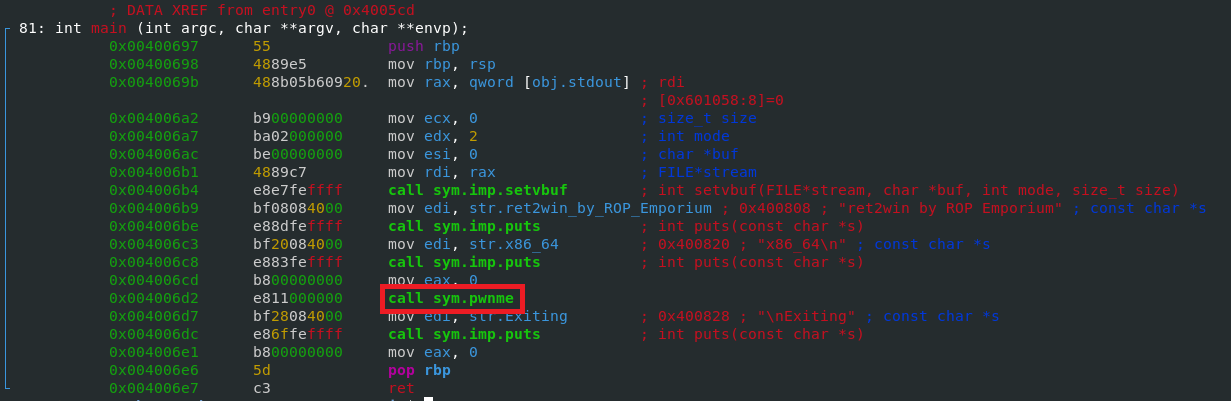
 



<h3>
Now were starting to cook with the gas stove, we can already see where the program calls into pwnme toward the bottom!
</h3>

<h3>
Now to check under the hood of the pwnme function...
</h3> 


# 
 



In [ ]:

cmd = "r2 -q -AAA ret2win -c 's sym.pwnme' -c pdf"


# 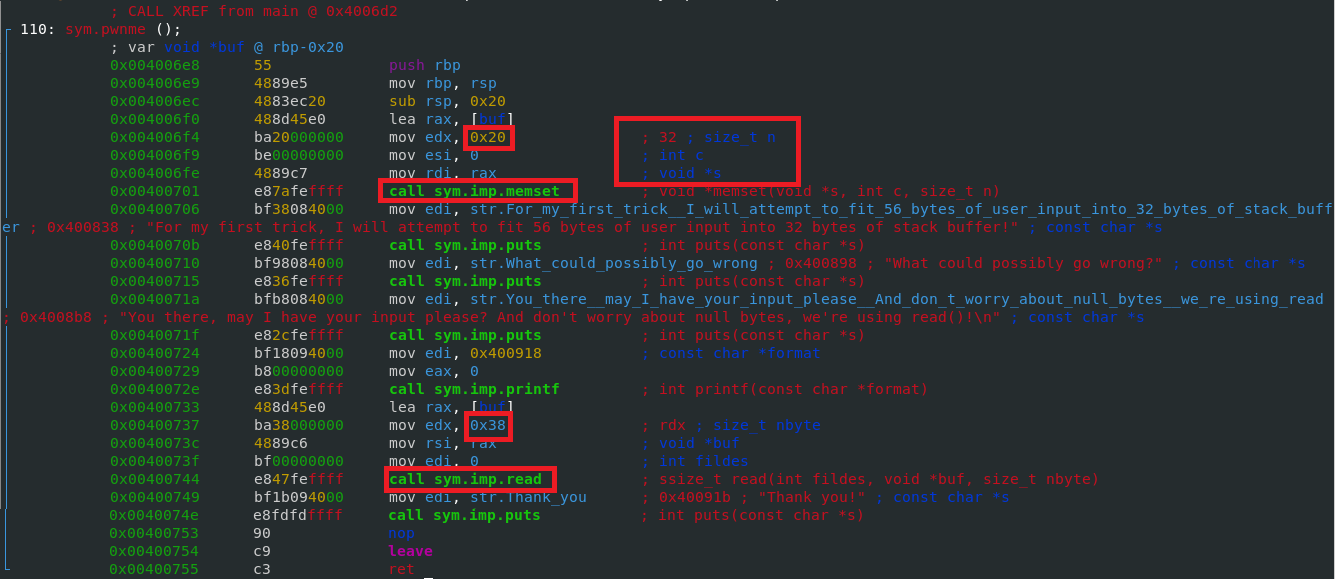
 



<h3>
Right so the vulnerability is definitely here, ROP Emporium does a good job of making RE light and whimsical. Getting into the buffer overflow itself, the first thing that sticks out is  memset (fills a given memory space with bytes). The comment indicates that memset takes a pointer, an int, and a size, using that ordering we can see the instructions directly above correspond to those arguments but are executed in reverse order.
</h3>

<h3>
r2 tells us in the comments that 0x20 is 32 and we can infer from the strings that 0x38 is 56. Lower down we can see that read is called with 0x38 bytes as it's desired size. Key point is we have 56 bytes of junk being written into a buffer that only wants 32 bytes. So this buffer overflow gives a plentiful 18 bytes to chain an exploit.
</h3> 

<h3>
Now for the last function of interest, ret2win:
</h3> 


# 
 



In [ ]:

cmd = "r2 -q -AAA ret2win -c 's sym.ret2win' -c pdf"

# 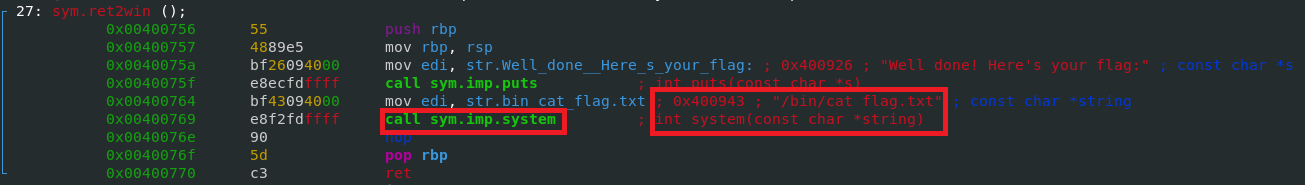
 



<h3>
Check out that call to system, looks like all we have to do is return in order to beat this level!
</h3>

<h3>
Now for the exploit... Just need to make a suitable python script that abuses the buffer overflow to overwrite the EIP so that we can jump on over to ret2win avoiding the programs intended crash.
</h3>

# 
 

